<a href="https://colab.research.google.com/github/andrewmarcello1-dev/Portfolio/blob/main/Solving_PDEs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

For dt = 1/500
Max Error of Explicit: 0.0063801
Max Error of Implicit: 0.0001175
Max Error of Crank-Nicholson: 0.0000953



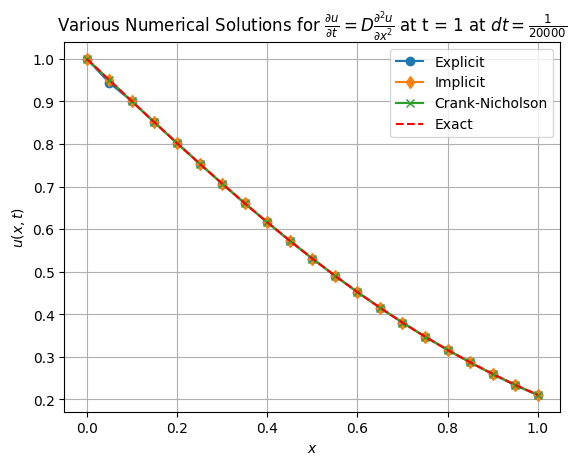

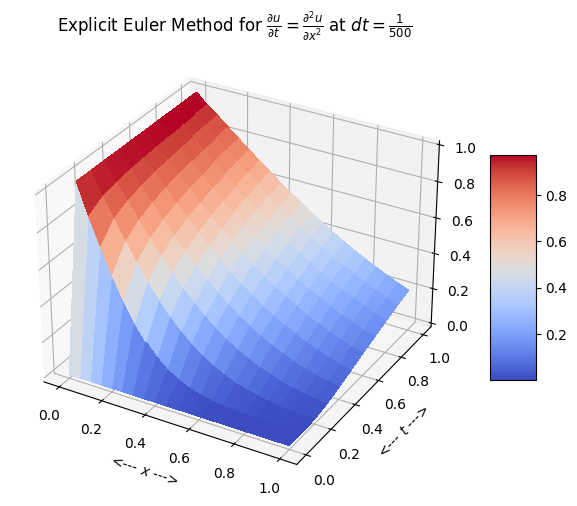

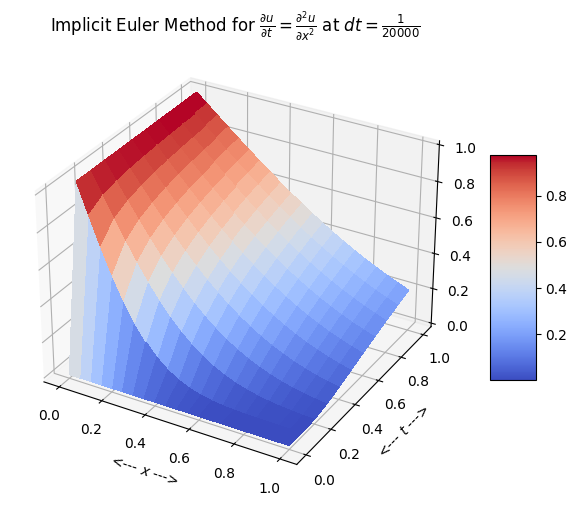

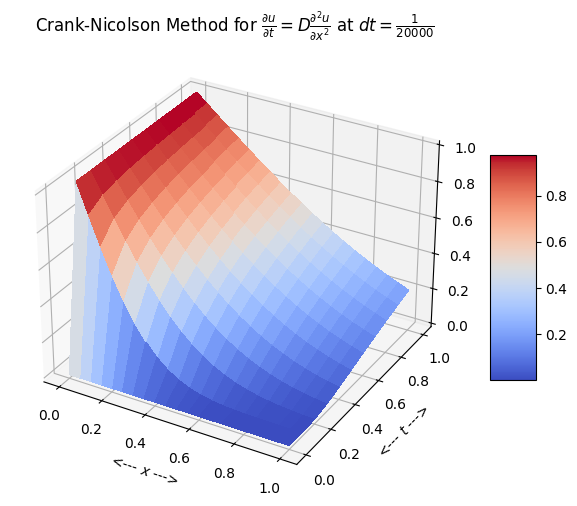

In [ ]:
#!/usr/bin/env python3
"""
===============================================================================
MA448 - Project 3 (1-a)
To solve one dimensial diffusion equation
     u_t = D • u_xx for 0<=x<=L, 0<=t<=T
with the initial and boundary conditions:
    u(x,0)=0
    u(0,t)=0
using the following methods:
     % ------------------------------------------------------------------
     % 1. Explicit Euler
     %    U_n+1=AU_n, A=[I+(dt/dx^2)[1,-2,1]]
     % 2. Implicit Euler
     %    AU_n+1=U_n, A=[I-(dt/dx^2)[1,-2,1]]
     % 3. Crank-Nicolson
     %    AU_n+1=CU_n, A=[2I-(dt/dx^2)[1,-2,1]], C=[2I+(dt/dx^2)[1,-2,1]]
===============================================================================
"""
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy.special import erf

def exact_solution(x, t):
    ue=np.zeros(len(x))
    for i in range(len(x)):
        ue[i]=1 - erf(x[i] / (2 * np.sqrt(D * t)))
    return ue

# Initial Condition
def u_init(x):
    u = np.zeros(len(x))
    return u

def ftcs(u1,dx,dt,tn):
    N=len(u1)
    u2=np.zeros(N)
    B=np.zeros((N-2,N-2))
    alpha=D*dt/(dx*dx)
    b = np.zeros(N-2)
    b = u1[1:N-1]
    b[0] = b[0] + alpha*u1[0]
    b[-1] = b[-1] + alpha*u1[-1]
    for i in range(N-2):
        B[i][i]=-2
        if i>0:
            B[i-1][i]=1; B[i][i-1]=1
    A=np.identity(N-2)+alpha*B #A=[I+(dt/dx^2)[1,-2,1]]
    u2[1:N-1]=np.dot(A,b)
    # Insert the boundary conditions u(0,t)=u(L,t)=0
    u2[0]=1; u2[N-1]=1 - erf(L / (2 * np.sqrt(D * tn)))
    return u2

def btcs(u1,dx,dt,tn):
    N=len(u1)
    u2=np.zeros(N)
    B=np.zeros((N-2,N-2))
    alpha=D*dt/(dx*dx)
    b = np.zeros(N-2)
    b = u1[1:N-1]
    b[0] = b[0] + alpha*u1[0]
    b[-1] = b[-1] + alpha*u1[-1]
    # Update PDE in the internal nodes
    for i in range(N-2):
        B[i][i]=-2
        if i>0:
            B[i-1][i]=1; B[i][i-1]=1
    A=np.identity(N-2)-alpha*B #A=[I-(dt/dx^2)[1,-2,1]]
    u2[1:N-1]=np.linalg.solve(A,b)
    # Insert the boundary conditions u(0,t)=u(L,t)=0
    u2[0]=1; u2[N-1]=1 - erf(L / (2 * np.sqrt(D * tn)))
    return u2

def cn(u1,dx,dt,tn):
    N=len(u1)
    u2=np.zeros(N)
    B=np.zeros((N-2,N-2))
    alpha=D*dt/(dx*dx)
    b = np.zeros(N-2)
    b[0] = b[0] + 2*alpha
    b[-1] = b[-1] + alpha*(1-erf(L/(2* np.sqrt(D*tn))) + 1 - erf(L/(2* np.sqrt(D*(tn+dt)))))
    # Update PDE in the internal nodes
    for i in range(N-2):
        B[i][i]=-2
        if i>0:
            B[i-1][i]=1; B[i][i-1]=1
    #Crank-Nicolson
    A=2*np.identity(N-2)-alpha*B #A=[2I-(dt/dx^2)[1,-2,1]]
    C=2*np.identity(N-2)+alpha*B #C=[2I+(dt/dx^2)[1,-2,1]]
    u2[1:N-1]=np.linalg.solve(A,np.dot(C,u1[1:N-1])+b)
    # Insert the boundary conditions u(0,t)=u(L,t)=0
    u2[0]=1; u2[N-1]=1 - erf(L / (2 * np.sqrt(D * tn)))
    return u2
#==============================================================================
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
if __name__=='__main__':
###############################################################################
    N=20  # Number of points in  x
    M=20000 # Number of points in  t
    out_num=10 # Number of times to save results for plotting

    L=1 # Length of the rod
    T=1 # End time
    D=1/np.pi # Diffusivity

    dx=L/N # Spatial step-size
    x=np.linspace(0,L,N+1) # x array to compute u(x[i])
    dt=T/M  # Temporal step-size
    u1=np.zeros(N+1) # u array
    u2=np.zeros(N+1)
    u3=np.zeros(N+1)

    t=np.linspace(0,T,out_num+1) # t array to save output
    sol_u1=np.zeros((out_num+1,N+1)) # Matrix where desired values are stored
    sol_u2=np.zeros((out_num+1,N+1))
    sol_u3=np.zeros((out_num+1,N+1))

    u=u_init(x) # Initial conditions For loop
    sol_u1[0,:]=u1 # Save initial values in the solution matrix
    sol_u2[0,:]=u2
    sol_u3[0,:]=u3
    P=M//out_num
    diff=P-1

    tn=0
    for n in range(1,M+1): # begin time stepping loop
        tn +=dt
        u1=ftcs(u1,dx,dt,tn)
        u2=btcs(u2,dx,dt,tn)
        u3=cn(u3,dx,dt,tn)

        ue=exact_solution(x,tn)

        if np.mod(n,P)==0 or n==M:
            for i in range(0,N+1):
                sol_u1[n-diff,i]=u1[i]
                sol_u2[n-diff,i]=u2[i]
                sol_u3[n-diff,i]=u3[i]
            diff = diff+P-1
    abs_err1=max(abs(u1-ue))
    abs_err2=max(abs(u2-ue))
    abs_err3=max(abs(u3-ue))
    # end time stepping loop

    print('For dt = 1/500')
    print('Max Error of Explicit: {0:.7f}\nMax Error of Implicit: {1:.7f}\nMax Error of Crank-Nicholson: {2:.7f}\n'.format(abs_err1,abs_err2,abs_err3))

    f1=plt.figure()
    plt.xlabel(r'$x$')
    plt.ylabel(r'$u(x,t)$')
    plt.title(r'Various Numerical Solutions for $\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}$ at t = 1 at $dt = \frac{1}{20000}$')
    plt.grid()
    plt.plot(x[:],sol_u1[-1,:],'o-',x[:],sol_u2[-1,:],'d-',x[:],sol_u3[-1,:],'x-',x,ue,'--r')
    plt.legend(['Explicit','Implicit','Crank-Nicholson','Exact'])
    plt.show()

    x_mat, t_mat = np.meshgrid ( x, t ) # create a grid of x and t for plotting
    u
    f2 = plt.figure ( )
    ax = f2.add_subplot ( 111, projection = '3d' )
    surf=ax.plot_surface ( x_mat, t_mat, sol_u1, cmap=cm.coolwarm, linewidth=0, antialiased=False )
    plt.tight_layout()
    plt.xlabel ( r'<--- $x$ --->' )
    plt.ylabel ( r'<--- $t$ --->' )
    plt.title(r'Explicit Euler Method for $\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}$ at $dt = \frac{1}{500}$')
    f2.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
    plt.show ( )

    f3 = plt.figure ( )
    ax = f3.add_subplot ( 111, projection = '3d' )
    surf=ax.plot_surface ( x_mat, t_mat, sol_u2, cmap=cm.coolwarm, linewidth=0, antialiased=False )
    plt.tight_layout()
    plt.xlabel ( r'<--- $x$ --->' )
    plt.ylabel ( r'<--- $t$ --->' )
    plt.title(r'Implicit Euler Method for $\frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2}$ at $dt = \frac{1}{20000}}$')
    f3.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
    plt.show ( )

    f4 = plt.figure ( )
    ax = f4.add_subplot ( 111, projection = '3d' )
    surf=ax.plot_surface ( x_mat, t_mat, sol_u3, cmap=cm.coolwarm, linewidth=0, antialiased=False )
    plt.tight_layout()
    plt.xlabel ( r'<--- $x$ --->' )
    plt.ylabel ( r'<--- $t$ --->' )
    plt.title(r'Crank-Nicolson Method for $\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}$ at $dt = \frac{1}{20000}$')
    f4.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
    f4.savefig ( 'fig2.png' )
    plt.show ( )



  s 	   nu 	 	   max_abs_error 	 rms_error
 100 	 0.0500 	 0.000647828978542 	0.000090238045440
 Explicit time steps required = 2222222
 Total time steps used = 2222222 x 100= 21100


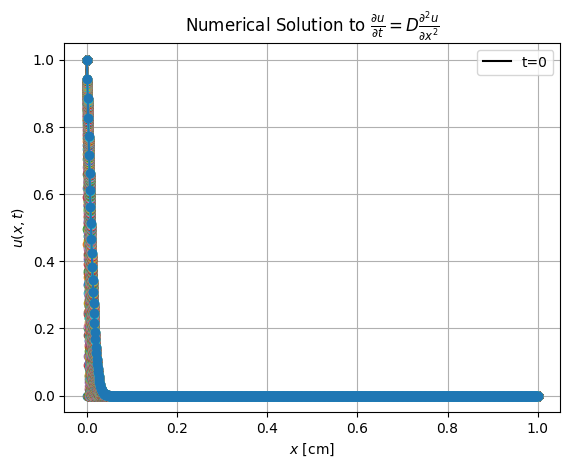

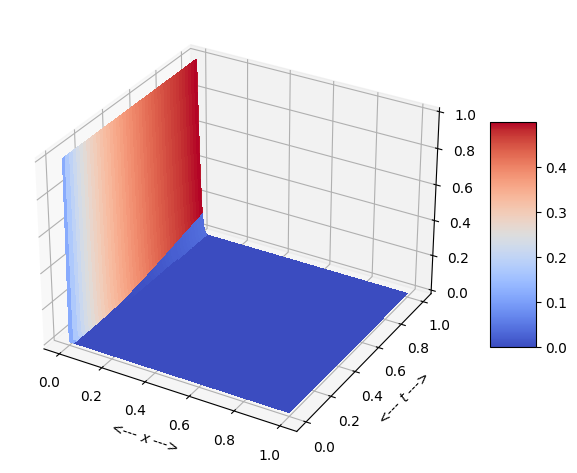

In [ ]:
"""
===============================================================================
MA448 - Project 3 (1-b)
To solve one dimensial diffusion equation
u_t = D • u_xx for 0<=x<=L, 0<=t<=T
with the initial and boundary conditions:
u(x,0)=0, u(0,t)=0
--------------------------------------
using Explicit Euler method
U_n+1=AU_n, A=[I+(dt/dx^2)[1,-2,1]]
with Super-Time-Stepping strategy
=============================================================================
"""
# Explicit Euler's Method
def update_pde_expl(u1,dx,dt):
  N=len(u1)
  u2=np.zeros(N)
  alpha=D*dt/(dx*dx)
  # internal nodes
  for i in range(1,N-1):
    u2[i]=u1[i]+alpha*(u1[i-1]-2*u1[i]+u1[i+1])
  # insert the boundary conditions u(0,t)=1, u(L,t)=0
  u2[0]=1; u2[N-1]=1 - erf(L / (2 * np.sqrt(D * tn)))
  return u2
# Super-Time-Stepping
def super_time_step(s,dt_expl,nu):
  """ Finds the substeps tau_i,i=0,1,2,...s-1 of a super-time-step"""
  tau=np.zeros(s)
  for i in range(s):
  # Small to large configuration
    supi = (2*i+1)/s
    supi = 2-supi
    super = (nu - 1)*np.cos(supi*np.pi/2)-nu+1
    tau[i] = dt_expl/super
  return tau
#==============================================================================
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
if __name__=='__main__':

  ###############################################################################
  N=1000 # Number of points in x
  s=100 # Number of substeps in a Super-Time-Step
  nu=0.05 # Damping parameter in the STS scheme
  dtfactor=0.9
  L=1 # Length of the rod
  T=1 # End time
  D=1 # Diffusivity
  dx=L/N # Spatial step-size
  x=np.linspace(0,L,N+1) # x array to compute u(x[i])
  u=np.zeros(N+1) # u array, approx sol
  ue=np.zeros(N+1) # ue array, exact sol

  #########################################################
  dt=dtfactor*dx**2/(2*D)
  M=int(T/dt)
  dt_expl=dtfactor*dx**2/(2*D)
  # Fix dt_explicit and find the number of time steps required
  M_expl=int(T/dt_expl)

  # Find the substeps tau_i, i=0,1,2,..,s-1 of a super-step
  tau=super_time_step(s,dt_expl,nu);
  sts_duration=np.sum(tau)

  # Find how many super time steps are needed
  M=int(T/sts_duration)

  ##############################################################
  t=np.linspace(0,T,M+1) # t array to save output
  sol_u=np.zeros((M+1,N+1)) # Matrix where desired values are stored

  # Initial condition
  tn=0
  u=u_init(x)
  sol_u[0,:]=u

  ######################################################
  # and make changes in the Time-Stepping loop below
  for j in range(M):
    tn += dt
    u=update_pde_expl(u,dx,dt)
    sol_u[j+1,:]=u
  ue = exact_solution(x,tn)
  max_err=np.max(abs(u-ue))
  rms_err=np.sqrt(np.sum(abs(u-ue)**2)/N)

  ######################################################
  # Uncomment the print statements for STS results
  # Print max absolute error and rms error at the end
  print('\n  s \t   nu \t \t   max_abs_error \t rms_error')
  print(' {0:2d} \t {1:0.4f} \t {2:0.15f} \t{3:0.15f}'.format(s,nu,max_err,rms_err))
  print(' Explicit time steps required = {0:d}'.format(M_expl))
  print(' Total time steps used = {0:d} x {1:d}= {2:d}'.format(M_expl,s,M*s))
  # Plot 1: u(x,t) plotted against x at various times
  f1=plt.figure()
  for j in range(0,len(sol_u[:,0])):
    if j==0:
      plt.plot(x[:],sol_u[j,:],'k-')
      plt.legend(['t=0'],loc='best')
      plt.xlabel(r'$x$ [cm]')
      plt.ylabel(r'$u(x,t)$')
      plt.title(r'Numerical Solution to $\frac{\partial u}{\partial t} = D\frac{\partial^2 u}{\partial x^2}$')
      plt.grid()
    else:
      plt.plot(x[:],sol_u[j,:],'o-')
  plt.show()

  x_mat, t_mat = np.meshgrid ( x, t ) # create a grid of x and t for plotting
  f2 = plt.figure ( )
  ax = f2.add_subplot ( 111, projection = '3d' )
  surf=ax.plot_surface ( x_mat, t_mat, sol_u, cmap=cm.coolwarm, linewidth=0,antialiased=False )
  plt.tight_layout()
  plt.xlabel ( r'<--- $x$ --->' )
  plt.ylabel ( r'<--- $t$ --->' )
  f2.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
  plt.show()

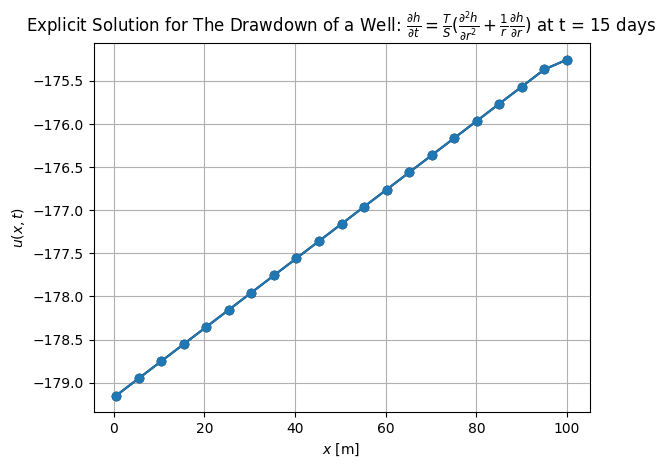

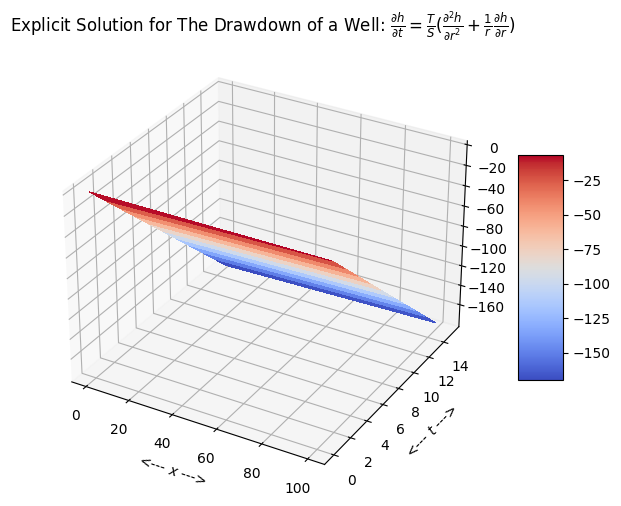

In [ ]:
"""
===============================================================================
MA448 - Project 3 (5-a)
To solve one dimensial diffusion equation
     h_t = T/S*(h_rr + 1/r * h_r) for 1/2<=r<=100, 0<=t<=15
with the initial and boundary conditions:
    h(x,0)=0
    h_r(1/2,t)=Q/(pi*T), h_r(100,t)=0
using the Explicit Euler Method
===============================================================================
"""
# Initial Condition
def u_init(x):
    np.zeros(len(x))
    return u

def ftcs(u1,dx,dt):
    N=len(u1)
    u2=np.zeros(N)
    B=np.zeros((N-2,N-2))
    alpha = Q/(np.pi*tm)
    mu = D*dt/(2*dx)
    lam=D*dt/(dx*dx)
    # Update PDE in the internal nodes
    for i in range(1,N-1):
        u2[i]=2*lam*u1[i-1]+(1-2*lam)*u1[i]
    # Insert the boundary conditions u(0,t)=u(L,t)=0
    u2[0]=(1-2*lam)*u1[0]+2*lam*u1[1]-2*dx*alpha*(lam-mu/2*x[0]); u2[N-1]=(lam-mu/x[N-1])*u1[i-1]+(1-2*lam)*u1[i]+(lam+mu/(2*x[N-1]))*u1[i+1]
    return u2
#==============================================================================
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
if __name__=='__main__':
###############################################################################
    N=20  # Number of points in  x
    M=10000 # Number of points in  t
    out_num=10 # Number of times to save results for plotting

    L=100 # Length of the rod
    T=15 # End time
    tm = 150
    S = 0.2
    Q = 100
    D=tm/S # Diffusivity


    dx=L/N # Spatial step-size
    x=np.linspace(1/2,L,N+1) # x array to compute u(x[i])
    dt=T/M  # Temporal step-size
    u=np.zeros(N+1) # u array
    t=np.linspace(0,T,out_num+1) # t array to save output
    sol_u=np.zeros((out_num+1,N+1)) # Matrix where desired values are stored

    u=u_init(x) # Initial conditions For loop
    sol_u[0,:]=u # Save initial values in the solution matrix

    P=M//out_num
    diff=P-1

    tn=0
    for n in range(1,M+1): # begin time stepping loop
        u=ftcs(u,dx,dt)
        if np.mod(n,P)==0 or n==M:
            for i in range(0,N+1):
                sol_u[n-diff,i]=u[i]
            diff = diff+P-1
    f1=plt.figure()
    plt.plot(x[:],sol_u[-1,:],'ko-')
    plt.xlabel(r'$x$ [m]')
    plt.ylabel(r'$u(x,t)$')
    plt.title(r'Explicit Solution for The Drawdown of a Well: $\frac{\partial h}{\partial t} = \frac{T}{S}(\frac{\partial^2 h}{\partial r^2} + \frac{1}{r} \frac{\partial h}{\partial r})$ at t = 15 days')
    plt.grid()
    plt.plot(x[:],sol_u[-1,:],'o-')
    plt.show()

    x_mat, t_mat = np.meshgrid ( x, t ) # create a grid of x and t for plotting

    f2 = plt.figure ( )
    ax = f2.add_subplot ( 111, projection = '3d' )
    surf=ax.plot_surface ( x_mat, t_mat, sol_u, cmap=cm.coolwarm, linewidth=0, antialiased=False )
    plt.tight_layout()
    plt.xlabel ( r'<--- $x$ --->' )
    plt.ylabel ( r'<--- $t$ --->' )
    plt.title(r'Explicit Solution for The Drawdown of a Well: $\frac{\partial h}{\partial t} = \frac{T}{S}(\frac{\partial^2 h}{\partial r^2} + \frac{1}{r} \frac{\partial h}{\partial r})$')
    f2.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
    plt.show ( )



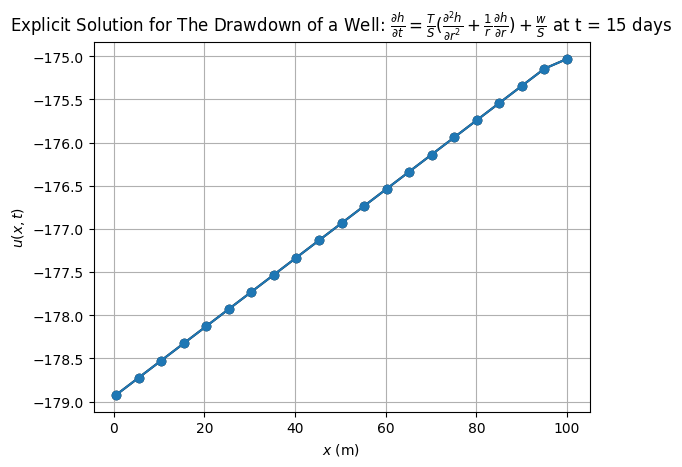

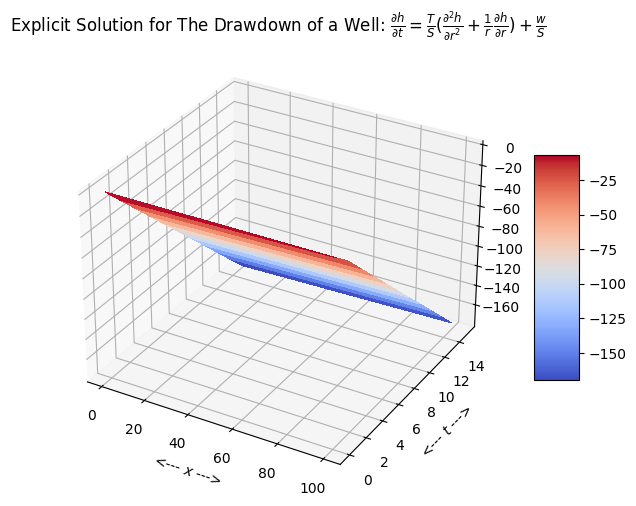

In [ ]:
"""
===============================================================================
MA448 - Project 3 (5-b)
To solve one dimensial diffusion equation
     h_t = T/S*(h_rr + 1/r * h_r) + w/S for 1/2<=r<=100, 0<=t<=15
with the initial and boundary conditions:
    h(x,0)=0
    h_r(1/2,t)=Q/(pi*T), h_r(100,t)=0
using the Explicit Euler Method
===============================================================================
"""
# Initial Condition
def ftcs(u1,dx,dt):
    N=len(u1)
    u2=np.zeros(N)
    B=np.zeros((N-2,N-2))
    alpha = Q/(np.pi*tm)
    mu = D*dt/(2*dx)
    lam=D*dt/(dx*dx)
    # Update PDE in the internal nodes
    for i in range(1,N-1):
        u2[i]=2*lam*u1[i-1]+(1-2*lam)*u1[i]+dt*(w/S)
    # Insert the boundary conditions u(0,t)=u(L,t)=0
    u2[0]=(1-2*lam)*u1[0]+2*lam*u1[1]-2*dx*alpha*(lam-mu/2*x[0])+dt*(w/S); u2[N-1]=(lam-mu/x[N-1])*u1[i-1]+(1-2*lam)*u1[i]+(lam+mu/(2*x[N-1]))*u1[i+1]+dt*(w/S)
    return u2
#==============================================================================
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%#
if __name__=='__main__':
###############################################################################
    N=20  # Number of points in  x
    M=10000 # Number of points in  t
    out_num=10 # Number of times to save results for plotting

    L=100 # Length of the rod
    T=15 # End time
    tm = 150
    S = 0.2
    Q = 100
    w = 0.003
    D=tm/S # Diffusivity


    dx=L/N # Spatial step-size
    x=np.linspace(1/2,L,N+1) # x array to compute u(x[i])
    dt=T/M  # Temporal step-size
    u=np.zeros(N+1) # u array
    t=np.linspace(0,T,out_num+1) # t array to save output
    sol_u=np.zeros((out_num+1,N+1)) # Matrix where desired values are stored

    u=u_init(x) # Initial conditions For loop
    sol_u[0,:]=u # Save initial values in the solution matrix

    P=M//out_num
    diff=P-1

    tn=0
    for n in range(1,M+1): # begin time stepping loop
        u=ftcs(u,dx,dt)
        if np.mod(n,P)==0 or n==M:
            for i in range(0,N+1):
                sol_u[n-diff,i]=u[i]
            diff = diff+P-1
    f1=plt.figure()
    plt.plot(x[:],sol_u[-1,:],'ko-')
    plt.xlabel(r'$x$ (m)')
    plt.ylabel(r'$u(x,t)$')
    plt.title(r'Explicit Solution for The Drawdown of a Well: $\frac{\partial h}{\partial t} = \frac{T}{S}(\frac{\partial^2 h}{\partial r^2} + \frac{1}{r} \frac{\partial h}{\partial r}) + \frac{w}{S}$ at t = 15 days')
    plt.grid()
    plt.plot(x[:],sol_u[-1,:],'o-')
    plt.show()

    x_mat, t_mat = np.meshgrid ( x, t ) # create a grid of x and t for plotting

    f2 = plt.figure ( )
    ax = f2.add_subplot ( 111, projection = '3d' )
    surf=ax.plot_surface ( x_mat, t_mat, sol_u, cmap=cm.coolwarm, linewidth=0, antialiased=False )
    plt.tight_layout()
    plt.xlabel ( r'<--- $x$ --->' )
    plt.ylabel ( r'<--- $t$ --->' )
    plt.title(r'Explicit Solution for The Drawdown of a Well: $\frac{\partial h}{\partial t} = \frac{T}{S}(\frac{\partial^2 h}{\partial r^2} + \frac{1}{r} \frac{\partial h}{\partial r}) + \frac{w}{S}$')
    f2.colorbar(surf, shrink=0.5, aspect=5) # add a color bar
    plt.show ( )